In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
import ipinfo
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

In [2]:
#load data and ensure it's good
df = pd.read_csv("Data\Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv")

df.columns = df.columns.str.lstrip()
df.columns = df.columns.str.replace(' ', '_')
df.columns = df.columns.str.replace('/s', '_s')
df.columns = df.columns.str.replace('Fwd_Header_Length.1', 'Fwd_Header_Length1')
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df=df.fillna(0)
df["Target"] = np.where(df["Label"] == "BENIGN", 0, 1)

<ipython-input-2-e18fbb08df8f>:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df.columns = df.columns.str.replace('Fwd_Header_Length.1', 'Fwd_Header_Length1')


In [3]:
df.head()

,Flow_ID,Source_IP,Source_Port,Destination_IP,Destination_Port,Protocol,Timestamp,Flow_Duration,Total_Fwd_Packets,Total_Backward_Packets,Total_Length_of_Fwd_Packets,Total_Length_of_Bwd_Packets,Fwd_Packet_Length_Max,Fwd_Packet_Length_Min,Fwd_Packet_Length_Mean,Fwd_Packet_Length_Std,Bwd_Packet_Length_Max,Bwd_Packet_Length_Min,Bwd_Packet_Length_Mean,Bwd_Packet_Length_Std,Flow_Bytes_s,Flow_Packets_s,Flow_IAT_Mean,Flow_IAT_Std,Flow_IAT_Max,Flow_IAT_Min,Fwd_IAT_Total,Fwd_IAT_Mean,Fwd_IAT_Std,Fwd_IAT_Max,Fwd_IAT_Min,Bwd_IAT_Total,Bwd_IAT_Mean,Bwd_IAT_Std,Bwd_IAT_Max,Bwd_IAT_Min,Fwd_PSH_Flags,Bwd_PSH_Flags,Fwd_URG_Flags,Bwd_URG_Flags,Fwd_Header_Length,Bwd_Header_Length,Fwd_Packets_s,Bwd_Packets_s,Min_Packet_Length,Max_Packet_Length,Packet_Length_Mean,Packet_Length_Std,Packet_Length_Variance,FIN_Flag_Count,SYN_Flag_Count,RST_Flag_Count,PSH_Flag_Count,ACK_Flag_Count,URG_Flag_Count,CWE_Flag_Count,ECE_Flag_Count,Down/Up_Ratio,Average_Packet_Size,Avg_Fwd_Segment_Size,Avg_Bwd_Segment_Size,Fwd_Header_Length1,Fwd_Avg_Bytes/Bulk,Fwd_Avg_Packets/Bulk,Fwd_Avg_Bulk_Rate,Bwd_Avg_Bytes/Bulk,Bwd_Avg_Packets/Bulk,Bwd_Avg_Bulk_Rate,Subflow_Fwd_Packets,Subflow_Fwd_Bytes,Subflow_Bwd_Packets,Subflow_Bwd_Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active_Mean,Active_Std,Active_Max,Active_Min,Idle_Mean,Idle_Std,Idle_Max,Idle_Min,Label,Target
0,192.168.10.5-104.16.207.165-54865-443-6,104.16.207.165,443,192.168.10.5,54865,6,7/7/2017 3:30,3,2,0,12,0,6,6,6.0,0.0,0,0,0.0,0.0,4.000000e+06,666666.66670,3.0,0.0,3,3,3,3.0,0.0,3,3,0,0.0,0.0,0,0,0,0,0,0,40,0,666666.666700,0.000000,6,6,6.0,0.0,0.0,0,0,0,0,1,0,0,0,0,9.0,6.0,0.0,40,0,0,0,0,0,0,2,12,0,0,33,-1,1,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN,0
1,192.168.10.5-104.16.28.216-55054-80-6,104.16.28.216,80,192.168.10.5,55054,6,7/7/2017 3:30,109,1,1,6,6,6,6,6.0,0.0,6,6,6.0,0.0,1.100917e+05,18348.62385,109.0,0.0,109,109,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,20,20,9174.311927,9174.311927,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,1,9.0,6.0,6.0,20,0,0,0,0,0,0,1,6,1,6,29,256,0,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN,0
2,192.168.10.5-104.16.28.216-55055-80-6,104.16.28.216,80,192.168.10.5,55055,6,7/7/2017 3:30,52,1,1,6,6,6,6,6.0,0.0,6,6,6.0,0.0,2.307692e+05,38461.53846,52.0,0.0,52,52,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,20,20,19230.769230,19230.769230,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,1,9.0,6.0,6.0,20,0,0,0,0,0,0,1,6,1,6,29,256,0,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN,0
3,192.168.10.16-104.17.241.25-46236-443-6,104.17.241.25,443,192.168.10.16,46236,6,7/7/2017 3:30,34,1,1,6,6,6,6,6.0,0.0,6,6,6.0,0.0,3.529412e+05,58823.52941,34.0,0.0,34,34,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,20,20,29411.764710,29411.764710,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,1,9.0,6.0,6.0,20,0,0,0,0,0,0,1,6,1,6,31,329,0,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN,0
4,192.168.10.5-104.19.196.102-54863-443-6,104.19.196.102,443,192.168.10.5,54863,6,7/7/2017 3:30,3,2,0,12,0,6,6,6.0,0.0,0,0,0.0,0.0,4.000000e+06,666666.66670,3.0,0.0,3,3,3,3.0,0.0,3,3,0,0.0,0.0,0,0,0,0,0,0,40,0,666666.666700,0.000000,6,6,6.0,0.0,0.0,0,0,0,0,1,0,0,0,0,9.0,6.0,0.0,40,0,0,0,0,0,0,2,12,0,0,32,-1,1,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN,0


In [4]:
print(df.shape)
print(df.isna().sum())
print()
print(df.isin([np.inf, -np.inf]).sum())

(225745, 86)
Flow_ID                        0
Source_IP                      0
Source_Port                    0
Destination_IP                 0
Destination_Port               0
Protocol                       0
Timestamp                      0
Flow_Duration                  0
Total_Fwd_Packets              0
Total_Backward_Packets         0
Total_Length_of_Fwd_Packets    0
Total_Length_of_Bwd_Packets    0
Fwd_Packet_Length_Max          0
Fwd_Packet_Length_Min          0
Fwd_Packet_Length_Mean         0
Fwd_Packet_Length_Std          0
Bwd_Packet_Length_Max          0
Bwd_Packet_Length_Min          0
Bwd_Packet_Length_Mean         0
Bwd_Packet_Length_Std          0
Flow_Bytes_s                   0
Flow_Packets_s                 0
Flow_IAT_Mean                  0
Flow_IAT_Std                   0
Flow_IAT_Max                   0
Flow_IAT_Min                   0
Fwd_IAT_Total                  0
Fwd_IAT_Mean                   0
Fwd_IAT_Std                    0
Fwd_IAT_Max                   

In [5]:
features = np.float32(df.loc[:, ~df.columns.isin(['Flow_ID', 'Source_IP', 'Destination_IP', 'Timestamp', 'Label', 'Target'])].copy().values) #reduce memory usage
label = df.loc[:, df.columns.isin(['Target'])].copy().values.ravel()

In [23]:
from sklearn.ensemble import RandomForestClassifier #use this when label is categorical

# Train a random forest classifier on the dataset
forest = RandomForestClassifier(n_estimators = 100, random_state=42)
forest.fit(features, label)

# Get the feature importances and sort them in descending order
importances = forest.feature_importances_
sorted_indices = importances.argsort()[::-1]
feature_names = df.loc[:, ~df.columns.isin(['Flow_ID', 'Source_IP', 'Destination_IP', 'Timestamp', 'Label', 'Target'])].copy().columns

# Print the top 10 features by importance
top_features = 10
for index in sorted_indices[:top_features]:
    print(f"{feature_names[index]}: {importances[index]}")

Fwd_Packet_Length_Mean: 0.08795648165522633
Fwd_Packet_Length_Max: 0.07329714493655393
act_data_pkt_fwd: 0.0632073052629421
Avg_Fwd_Segment_Size: 0.057112287950109274
Fwd_IAT_Std: 0.05446025902556625
Subflow_Fwd_Bytes: 0.053062363702371156
Total_Fwd_Packets: 0.046586411788585594
Init_Win_bytes_forward: 0.045311311471479036
Fwd_Header_Length1: 0.043790005482903245
Destination_Port: 0.036545022644347266


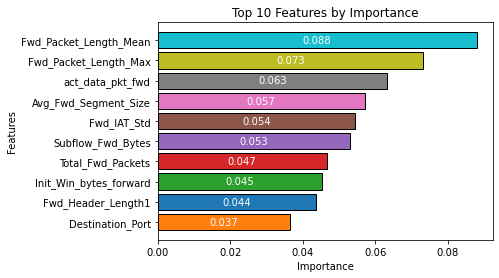

In [24]:
# Create a horizontal bar plot of feature importances
fig, ax = plt.subplots()
ax.barh(range(top_features), importances[sorted_indices][:top_features][::-1], align='center', color=['#ff7f0e','#1f77b4','#2ca02c','#d62728','#9467bd','#8c564b','#e377c2','#7f7f7f','#bcbd22','#17becf'])

# Add labels to the plot
ax.set_yticks(range(top_features))
ax.set_yticklabels(feature_names[sorted_indices][:top_features][::-1])
ax.set_xlabel('Importance')
ax.set_ylabel('Features')
ax.set_title('Top 10 Features by Importance')

# Add a frame around each bar
for i, patch in enumerate(ax.patches):
    patch.set_edgecolor('#000000')
    patch.set_linewidth(1)

    # Add the importance value to the middle of each bar
    x = patch.get_x() + patch.get_width() / 2
    y = patch.get_y() + patch.get_height() / 2
    ax.text(x, y, round(importances[sorted_indices][:top_features][::-1][i], 3), ha='center', va='center', color='#ffffff')

plt.show()

In [10]:
names = ['Destination_Port', 'Fwd_Packet_Length_Max', "Avg_Fwd_Segment_Size", "Fwd_Packet_Length_Mean", "Subflow_Fwd_Bytes",
        "Total_Length_of_Fwd_Packets", "Source_Port", "Init_Win_bytes_forward"]
'''"Fwd_Packet_Length_Std", "Init_Win_bytes_backward",
        "act_data_pkt_fwd", "Bwd_Packet_Length_Mean", "Avg_Bwd_Segment_Size", "Fwd_IAT_Total", "min_seg_size_forward", "Fwd_IAT_Max",
        "Bwd_Packet_Length_Max", "Average_Packet_Size", "Bwd_Packet_Length_Std", "Packet_Length_Mean"'''
features = np.float32(df.loc[:, df.columns.isin(names)].copy().values) #reduce memory usage

In [27]:
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time

# Use the top 10 features
X = features
y = df['Target'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train and evaluate several classifiers
models = {
    "Gaussian Naive Bayes": GaussianNB(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier()
}

for name, model in models.items():
    s_time = time.time()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    e_time = time.time()
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"{name}:")
    print(f"Accuracy: {accuracy:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    print(f"F1 score: {f1:.3f}")
    print(f"Running time: {e_time - s_time:.3f} seconds\n")

Gaussian Naive Bayes:
Accuracy: 0.796
Precision: 0.736
Recall: 1.000
F1 score: 0.848
Running time: 0.229 seconds

K-Nearest Neighbors:
Accuracy: 0.989
Precision: 0.989
Recall: 0.992
F1 score: 0.991
Running time: 401.435 seconds

Decision Tree:
Accuracy: 1.000
Precision: 1.000
Recall: 1.000
F1 score: 1.000
Running time: 1.207 seconds

Random Forest:
Accuracy: 1.000
Precision: 1.000
Recall: 1.000
F1 score: 1.000
Running time: 30.397 seconds



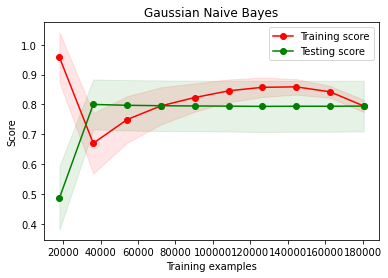

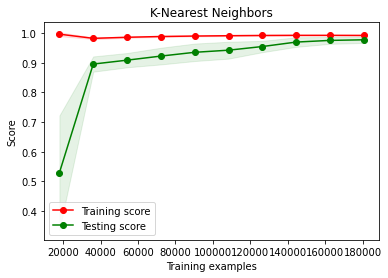

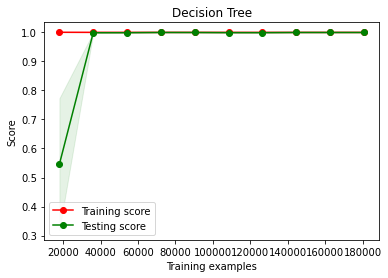

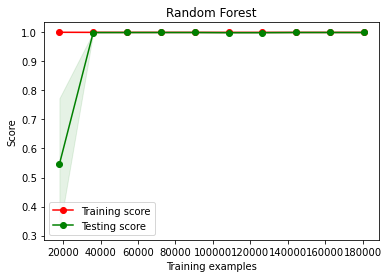

In [13]:
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import learning_curve

# Define the models to use
models = {
    "Gaussian Naive Bayes": GaussianNB(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier()
}

X = np.float32(df.loc[:, df.columns.isin(['Fwd_Packet_Length_Mean', 'Fwd_Packet_Length_Max', "act_data_pkt_fwd", "Avg_Fwd_Segment_Size", "Fwd_IAT_Std",
        "Subflow_Fwd_Bytes", "Total_Fwd_Packets", "Init_Win_bytes_forward", "Fwd_Header_Length1", "Destination_Port"])].copy().values)
y = df['Target'].values

# Plot the learning curve for each model
for name, model in models.items():
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=5, n_jobs=-1,
                                                            train_sizes=np.linspace(0.1, 1.0, 10))
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_mean, 'o-', color="g", label="Testing score")
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="g")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.title(f"{name}")
    plt.legend(loc="best")
    plt.show()